In [48]:
__author__ = 'zeshi'
import tarfile
from datetime import date, timedelta
import gzip
import os
from gdal import GA_ReadOnly
import gdal
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from pandas import Series, date_range
from recon_lidar_error_stat import resample_lidar, reproject_reconstruction
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
%matplotlib inline

In [18]:
def untargz_snodas(date):
    folder_name = "SNODAS/" + str(date.year) + "/" + str(date.month).zfill(2) + "_" + date.strftime("%B")[0:3] + "/"
    tar_fn = folder_name + "SNODAS_" + str(date.year) + str(date.month).zfill(2) + str(date.day).zfill(2)+ ".tar"
    file = tarfile.open(tar_fn, "r:")
    dat_member_name = "./us_ssmv11034tS__T0001TTNATS" + str(date.year) + str(date.month).zfill(2) + str(date.day).zfill(2) + \
                      "05HP001.dat.gz"
    hdr_member_name = "./us_ssmv11034tS__T0001TTNATS" + str(date.year) + str(date.month).zfill(2) + str(date.day).zfill(2) + \
                      "05HP001.Hdr.gz"
    dat_member = file.getmember(dat_member_name)
    hdr_member = file.getmember(hdr_member_name)
    file.extract(dat_member, path=folder_name)
    file.extract(hdr_member, path=folder_name)
    dat_gz_fn = folder_name + dat_member_name
    hdr_gz_fn = folder_name + hdr_member_name
    dat_file = gzip.open(dat_gz_fn, "rb")
    dat_outF = open(dat_gz_fn[:-3], "wb")
    hdr_file = gzip.open(hdr_gz_fn, "rb")
    hdr_outF = open(hdr_gz_fn[:-3], "wb")
    dat_outF.write(dat_file.read())
    for i, line in enumerate(hdr_file):
        if i >= 0 and i <= 1:
            hdr_outF.write(line)
        if i >= 18 and i <= 57:
            hdr_outF.write(line)
    dat_file.close()
    dat_outF.close()
    hdr_file.close()
    hdr_outF.close()
    os.remove(dat_gz_fn)
    os.remove(hdr_gz_fn)

In [19]:
def untargz_all_snodas():
    date_needed = [date(2014, 3, 23), date(2014, 4, 7), date(2014, 4, 13), date(2014, 4, 20), date(2014, 4, 28), 
                   date(2014, 4, 6), date(2014, 4, 14), 
                   date(2014, 4, 23), date(2014, 4, 29)]
    for temp_date in date_needed:
        untargz_snodas(temp_date)

In [20]:
# site_abbr, string, two options, ['TB', 'MB']
def lidar_snodas_format(site_abbr, date_obj):
    # Resample lidar data to 1000-m resolution
    lidar_folder_name = "3m_data/"
    date_str = str(date_obj.year) + str(date_obj.month).zfill(2) + str(date_obj.day).zfill(2)
    if site_abbr == 'TB':
        lidar_fn = lidar_folder_name + site_abbr + date_str + "_swe.tif"
        lidar_match_fn = lidar_folder_name + "Tuolumne_1000m_DEM.tif"
    else:
        lidar_fn = lidar_folder_name + site_abbr + date_str + "_SUPERsnow_depth_EXPORT.tif"
        lidar_match_fn = lidar_folder_name + "Merced_1000m_DEM.tif"
    lidar_fn_dst = lidar_folder_name + site_abbr + date_str + "_1000m.tif"
    reproject_reconstruction(lidar_fn, lidar_match_fn, lidar_fn_dst, lidar=True)

    folder_name = "SNODAS/" + str(date_obj.year) + "/" + str(date_obj.month).zfill(2) + "_" + \
                  date_obj.strftime("%B")[0:3] + "/"
    file_name = "us_ssmv11034tS__T0001TTNATS" + str(date_obj.year) + str(date_obj.month).zfill(2) + \
                str(date_obj.day).zfill(2) + "05HP001.Hdr"
    snodas_fn = folder_name + file_name
    snodas_fn_dst = lidar_folder_name + site_abbr + date_str + "_snodas.tif"
    reproject_reconstruction(snodas_fn, lidar_fn_dst, snodas_fn_dst)

In [21]:
def format_all_dates():
    tuolumne_dates = [date(2014, 3, 23), date(2014, 4, 7), date(2014, 4, 13), date(2014, 4, 20), date(2014, 4, 28)]
    merced_dates = [date(2014, 4, 6), date(2014, 4, 14), date(2014, 4, 23), date(2014, 4, 29)]
    for tb_date in tuolumne_dates:
        lidar_snodas_format("TB", tb_date)
    for mb_date in merced_dates:
        lidar_snodas_format("MB", mb_date)

In [22]:
format_all_dates()

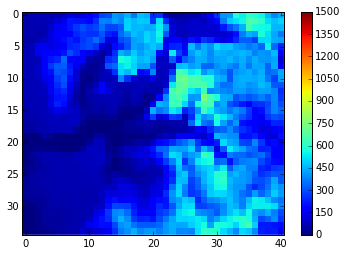

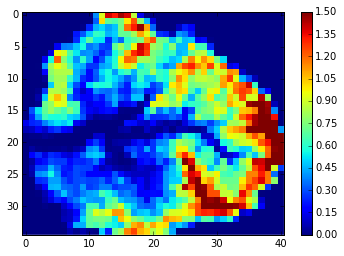

In [81]:
snodas_test = gdal.Open("3m_data/MB20140406_snodas.tif").ReadAsArray()
lidar_test = gdal.Open("3m_data/MB20140406_1000m.tif").ReadAsArray()
plt.imshow(snodas_test, interpolation='none', vmax=1500, vmin=0)
plt.colorbar()
plt.show()
plt.imshow(lidar_test, interpolation='none', vmax=1.5, vmin=0)
plt.colorbar()
plt.show()

In [78]:
def lidar_snodas_compare(site_abbr, date_obj):
    # Formatting the entire feature space
    folder_name = "3m_data/"
    date_str = str(date_obj.year) + str(date_obj.month).zfill(2) + str(date_obj.day).zfill(2)
    lidar_fn = folder_name + site_abbr + date_str + "_1000m.tif"
    snodas_fn = folder_name + site_abbr + date_str + "_snodas.tif"
    feature_space = None
    
    if site_abbr == "TB":
        fn_str = "Tuolumne_1000m_"
    else:
        fn_str = "Merced_1000m_"
        
    for feature in ["DEM", "ASP", "SLP", "NOR"]:
        feature_fn = folder_name + fn_str + feature + ".tif"
        if feature_space is None:
            feature_space = gdal.Open(feature_fn).ReadAsArray().flatten()
        else:
            feature_space = np.column_stack((feature_space, gdal.Open(feature_fn).ReadAsArray().flatten()))
    feature_space = np.column_stack((feature_space, gdal.Open(snodas_fn).ReadAsArray().flatten() / 1000.))
    feature_space = np.column_stack((feature_space, gdal.Open(lidar_fn).ReadAsArray().flatten()))
    
    
    # Calculate the difference between lidar and snodas
    feature_space = np.column_stack((feature_space, (feature_space[:, -1] - feature_space[:, -2])))
    feature_space = feature_space[feature_space[:, 0] >= 1500.]
    feature_space = feature_space[feature_space[:, -2] > 0.]
    feature_space = feature_space[feature_space[:, -3] > 0.]
    
    fig, axarr = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
    
    axarr[0].scatter(feature_space[:, 0], feature_space[:, -1], color='k', edgecolor='none')
    
    dtr = DecisionTreeRegressor(max_depth=4, min_samples_split=10, min_samples_leaf=10)
    dtr.fit(feature_space[:, 0][:, np.newaxis], feature_space[:, -1])
    predict_X = np.linspace(1500, 3700, 100)[:, np.newaxis]
    predict_Y = dtr.predict(predict_X)
    axarr[0].plot(predict_X, predict_Y, '-b', linewidth=5)
    axarr[0].grid()
    model_y = dtr.predict(feature_space[:, 0][:, np.newaxis])
    model_y_residual = feature_space[:, -1] - model_y
    
    lr = LinearRegression(fit_intercept=False)
    lr.fit(feature_space[:, 3][:, np.newaxis], model_y_residual)
    northness_X = np.linspace(-1, 1, 100)[:, np.newaxis]
    northness_Y = lr.predict(northness_X)
    
    axarr[1].scatter(feature_space[:, 3], model_y_residual, color='k', edgecolor='none')
    axarr[1].set_xlim([-0.3, 0.3])
    axarr[1].plot(northness_X, northness_Y, '-b', linewidth=5)
    axarr[1].grid()
    figure_fn = "figures/" + site_abbr + date_str + "_vs_snodas.pdf"
    plt.savefig(figure_fn)
    plt.show()

In [102]:
def lidar_snodas_anova(site_abbr):
    # date_obj
    if site_abbr == "TB":
        date_obj_list = [date(2014, 3, 23), date(2014, 4, 7), date(2014, 4, 13), date(2014, 4, 20), date(2014, 4, 28)]
        date_obj_list = [date(2014, 3, 23), date(2014, 4, 13)]
    else:
        date_obj_list = [date(2014, 4, 6), date(2014, 4, 14), date(2014, 4, 23), date(2014, 4, 29)]
    
    # Formatting the entire feature space
    error_array_list = []
    for date_obj in date_obj_list:
        folder_name = "3m_data/"
        date_str = str(date_obj.year) + str(date_obj.month).zfill(2) + str(date_obj.day).zfill(2)
        lidar_fn = folder_name + site_abbr + date_str + "_1000m.tif"
        snodas_fn = folder_name + site_abbr + date_str + "_snodas.tif"
        feature_space = None

        if site_abbr == "TB":
            fn_str = "Tuolumne_1000m_"
        else:
            fn_str = "Merced_1000m_"
        feature = "DEM"
        feature_fn = folder_name + fn_str + feature + ".tif"
        feature_space = gdal.Open(feature_fn).ReadAsArray().flatten()
        feature_space = np.column_stack((feature_space, gdal.Open(snodas_fn).ReadAsArray().flatten() / 1000.))
        feature_space = np.column_stack((feature_space, gdal.Open(lidar_fn).ReadAsArray().flatten()))
        # Calculate the difference between lidar and snodas
        feature_space = np.column_stack((feature_space, (feature_space[:, -1] - feature_space[:, -2])))
        feature_space = feature_space[feature_space[:, 0] >= 1500.]
        feature_space = feature_space[feature_space[:, -2] > 0.]
        feature_space = feature_space[feature_space[:, -3] > 0.]
        
        error_array_list.append(feature_space[:, -1])
    f_val, p_val = stats.f_oneway(*error_array_list)
    print "The p-value of one-way ANOVA is", p_val

In [103]:
lidar_snodas_anova("TB")

The p-value of one-way ANOVA is 3.07452774138e-16


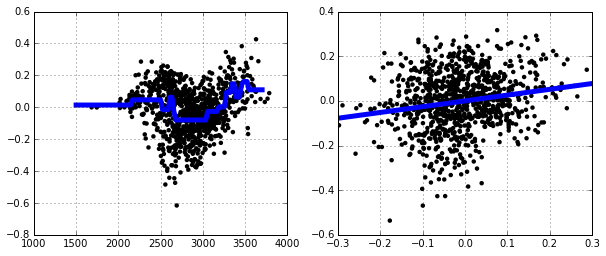

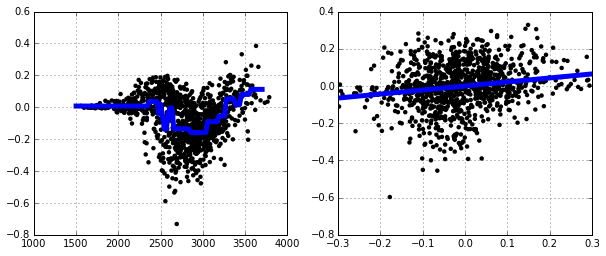

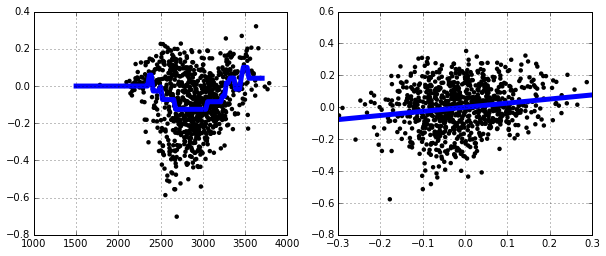

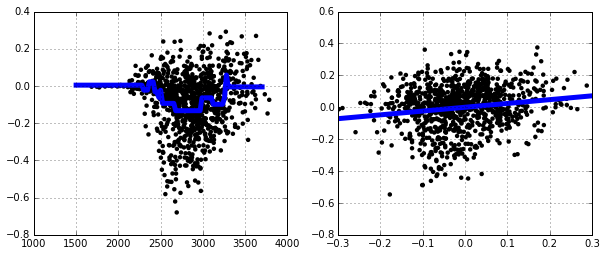

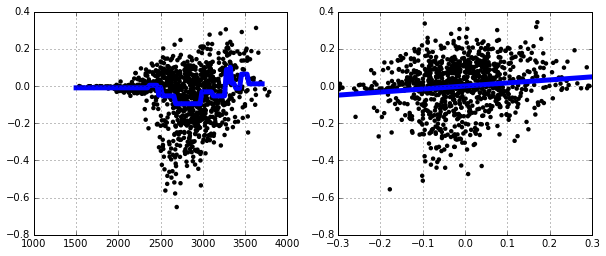

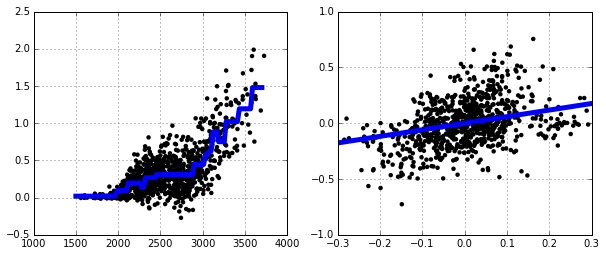

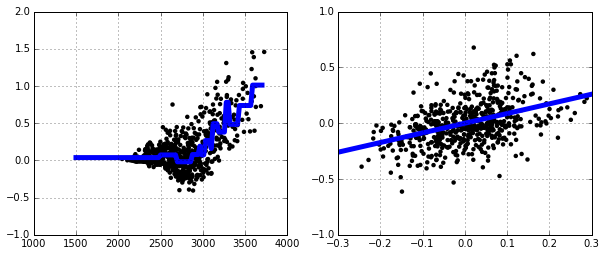

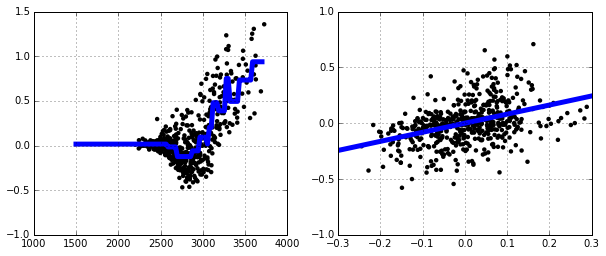

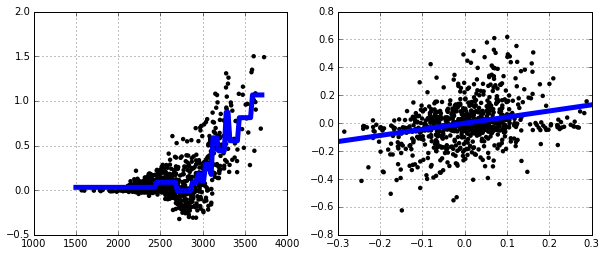

In [79]:
tuolumne_dates = [date(2014, 3, 23), date(2014, 4, 7), date(2014, 4, 13), date(2014, 4, 20), date(2014, 4, 28)]
merced_dates = [date(2014, 4, 6), date(2014, 4, 14), date(2014, 4, 23), date(2014, 4, 29)]
for tb_date in tuolumne_dates:
    lidar_snodas_compare("TB", tb_date)
for mb_date in merced_dates:
    lidar_snodas_compare("MB", mb_date)

In [82]:
from scipy import stats